## Operaciones de mapeo y reducción
El objetivo de esta libreta es revisar las operaciones Map-Reduce. Esta libreta está basada del material del Mtro. Efraín Condés.

### Introducción
MapReduce es un modelo de programación que nos permite procesar enormes cantidades de datos de forma distribuida sobre un clúster.

La idea principal consiste en primero transformar los datos de tal forma que tengan un formato (llave, valor) para después reducirlos, combinando de alguna manera todos los valores correspondientes a la misma llave.

Para realizar este proceso solo es necesario definir dos funciones:

- Map: Transforma los datos en pares (llave, valor).
- Reduce: Combina todos los valores asociados a la misma llave de alguna forma.

En este notebook nos daremos a la tarea de mostrar varios ejemplos de como llevar a cabo este modelo de programación usando Python y PySpark.

In [0]:
#Carga de bibliotecas
import pyspark
from pyspark.sql.functions import * 
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('MapReduce').getOrCreate()

In [0]:
#Carga de bibliotecas extras
import numpy as np
import matplotlib.pyplot as plt

#Carga de NLTK
import nltk
import string
from sentiment_analysis_spanish import sentiment_analysis

## Ejemplos básicos

Dado un conjunto de datos, revisaremos algunas de las combinaciones de funciones Map y Reduce más comunes. Para lograrlo crearemos un array con 100 números enteros y lo convertiremos a un RDD.

In [0]:
#1) Creando array con 100 números enteros
np.random.seed(182)
array_datos = np.random.randint(10, size=100)
array_datos[:10] #listemos los primeros 10 números

Out[39]: array([9, 8, 2, 2, 2, 5, 8, 8, 7, 2])

In [0]:
#Creación del RDD
rdd_numeros = spark.sparkContext.parallelize(array_datos)

# Revisemos el contenido del RDD
for elemento in rdd_numeros.take(5):
  print(elemento)

9
8
2
2
2


### Operación map
Supongamos ahora que queremos saber la distribución de los datos. Para esto podemos mapear los elementos de tal forma que: por cada número la llave será el número y el valor el número de apariciones de dicho número en cada renglón, es decir (número, 1). Esto lo podemos lograr con la función map de la siguiente forma:

In [0]:
rdd_conteo = rdd_numeros.map(lambda x: (x, 1))

for elemento in rdd_conteo.take(5):
  print(elemento)

(9, 1)
(8, 1)
(2, 1)
(2, 1)
(2, 1)


La función map también la podemos usar para transformar a los elementos del RDD de la forma en que queramos. Por ejemplo, podríamos querer obtener las 3 primeras potencias de cada elemento

In [0]:
# Podemos pasar una funcion 
def potencias(x):
  return (x**1, x**2, x**3)

# Aplicamos la función map
rdd_potencias = rdd_numeros.map(potencias)

# Imprimimos 
for elemento in rdd_potencias.take(5):
  print(elemento)

(9, 81, 729)
(8, 64, 512)
(2, 4, 8)
(2, 4, 8)
(2, 4, 8)


#### Operación Reduce
La operación Reduce asume que todos los valores corresponden a la misma llave, es decir se toma la función Map como la función identidad.

In [0]:
#Podemos usar la función Reduce para saber, por ejemplo, la suma de todos los elementos
suma = rdd_numeros.reduce(lambda a, b: a + b)
suma

Out[43]: 453

In [0]:
#También podríamos querer saber cual es el elemento máximo
maximo = rdd_numeros.reduce(lambda a, b: a if a > b else b)
maximo

Out[44]: 9

### Operación reduceByKey

Habiendo transformado nuestros datos en pares (llave, etiqueta) podemos aplicar una función de Reduce, para saber cuantas veces aparece cada numero. Para eso solo debemos sumar los valores para cada llave.

In [0]:
# Calculamos la suma para cada llave
rdd_histograma = rdd_conteo.reduceByKey(lambda a, b: a + b)
rdd_histograma.take(5)

Out[45]: [(8, 11), (0, 11), (9, 8), (1, 8), (2, 9)]

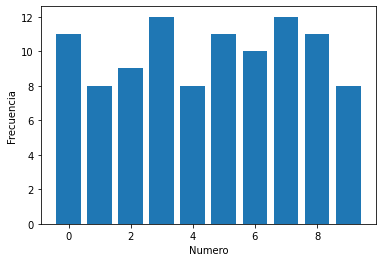

In [0]:
# Imprimimos el histograma
histograma = rdd_histograma.collect()

numeros = [ numero for (numero, _) in histograma ]
frecuencias = [ frecuencia for (_, frecuencia) in histograma ]
plt.bar(numeros, frecuencias)
plt.xlabel('Numero')
plt.ylabel('Frecuencia')
plt.show()

### Operación flatMap
Supongamos ahora que tenemos un texto separado por renglones de la siguiente manera

In [0]:
texto = ['esto se supone que es un parrafo del texto', 'este es el segundo parrafo del texto', 'agreguemos otro parrafo']

In [0]:
# A partir del texto, vamos a crear un RDD

rdd_texto = spark.sparkContext.parallelize(texto)

for parrafo in rdd_texto.collect():
  print(parrafo)

esto se supone que es un parrafo del texto
este es el segundo parrafo del texto
agreguemos otro parrafo


Pensemos que queremos contar cuantas veces aparece cada palabra en todo el texto. Una forma de hacerlo es creando pares (palabra, 1) (parecido al ejemplo pasado), sin embargo los elementos del RDD deberían ser las palabras no los párrafos.

Para esto existe la función flatMap, nos ayuda a "aplanar" los elementos del RDD. Observemos como funciona:

In [0]:
rdd_palabras = rdd_texto.flatMap(lambda parrafo: parrafo.split(' '))

for palabra in rdd_palabras.take(10):
  print(palabra)

esto
se
supone
que
es
un
parrafo
del
texto
este


In [0]:
#Hagamos el conteo de palabras
histograma_palabras = rdd_palabras.map(lambda palabra: (palabra, 1)) \
                                  .reduceByKey(lambda a, b: a + b) \
                                  .sortBy(lambda x: x[1], ascending = False) \
                                  .collect()

In [0]:
print ("{:<10} {:<10}".format('Palabra', 'Frecuencia'))

for palabra, frecuencia in histograma_palabras:
  print ("{:<10} {:<10}".format(palabra, frecuencia))

Palabra    Frecuencia
parrafo    3         
es         2         
del        2         
texto      2         
este       1         
el         1         
segundo    1         
se         1         
un         1         
agreguemos 1         
otro       1         
esto       1         
supone     1         
que        1         


Para mayor claridad, vamos a separar las operaciones de Map y Reduce:

In [0]:
# Operación Map (flapMap: cada renglón es una palabra, map: conteo por aparición)
rdd_par_palabras = rdd_texto.flatMap(lambda parrafo: parrafo.split(' ')) \
                            .map(lambda palabra: (palabra, 1))

print('Resultado: operación Map')
for par in rdd_par_palabras.take(5):
  print(par)

Resultado: operación Map
('esto', 1)
('se', 1)
('supone', 1)
('que', 1)
('es', 1)


In [0]:
# Operación Reduce
rdd_histograma_palabras = rdd_par_palabras.reduceByKey(lambda a, b: a + b) \
                                          .sortBy(lambda x: x[1], ascending = False)

print('Resultado: operación Reduce')
for par in rdd_histograma_palabras.take(5):
  print(par)   

Resultado: operación Reduce
('parrafo', 3)
('es', 2)
('del', 2)
('texto', 2)
('este', 1)


### mapValues

Otra función que puede resultar útil al momento de crear funciones Map es la de mapValues. Imaginemos que ahora tenemos tres textos diferentes

In [0]:
# Definicion de los texto
texto_1 = ['esto es un parrafo', 'otro_parrafo']
texto_2 = ['este texto solo tiene un parrafo']
texto_3 = ['parrafo 1', 'parrafo 2', 'parrafo 3']

textos = [('texto_1', texto_1), ('texto_2', texto_2), ('texto_3', texto_3)]

# Creación de un RDD con los textos
rdd_textos = spark.sparkContext.parallelize(textos)

for texto in rdd_textos.take(2):
  print(texto)

('texto_1', ['esto es un parrafo', 'otro_parrafo'])
('texto_2', ['este texto solo tiene un parrafo'])


Notemos que este RDD ya está formateado en pares (texto_id, texto). Si quisiéramos saber cuantos párrafos tiene cada texto deberíamos encontrar una forma de calcular len(texto) para cada par sin alterar la llave. Podemos hacer esto usando la función mapValues, que dado un par (llave, valor) aplica una transformación solo al valor.

In [0]:
rdd_num_parrafos = rdd_textos.mapValues(lambda valor: len(valor))

print ("{:<10} {:<10}".format('Texto', 'Num_parrafos'))

for texto, num_parrafos in rdd_num_parrafos.collect():
  print ("{:<10} {:<10}".format(texto, num_parrafos))

Texto      Num_parrafos
texto_1    2         
texto_2    1         
texto_3    3         


### Caso de estudio
Con el objetivo comprender a profundidad las operaciones de Map y Reduce, se usará una base de datos real de opiniones disponible por Amazon

In [0]:
#Instalación de bibliotecas adicionales
# Procesamiento del lenguaje natural
!pip install nltk
!pip install --upgrade pip
!python -m nltk.downloader all

!pip install sentiment-analysis-spanish
!pip install keras tensorflow

/usr/lib/python3.8/runpy.py:127: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_

In [0]:
rdd_amazon = spark.sparkContext.textFile('/FileStore/tables/amazon_alexa-1.csv').map(lambda x: x.split('*'))

for opinion in rdd_amazon.take(5):
  print(opinion)

['verified_reviews']
['Love my Echo!']
['Loved it!']
['"Sometimes while playing a game, you can answer a question correctly but Alexa says you got it wrong and answers the same as you.  I like being able to turn lights on and off while away from home."']
['"I have had a lot of fun with this thing. My 4 yr old learns about dinosaurs, i control the lights and play games like categories. Has nice sound when playing music as well."']


### Limpieza de datos
Se puede observar que las opiniones deben ser preprocesadas para poder analizados de una forma más eficiente. En nuestro caso nos enfocaremos en los siguientes puntos:

- Transformar todo el texto a minúsculas.
- Eliminar signos de puntuación.
- Eliminar las palabras vacías, que son palabras que aportan poco contexto al problema.

In [0]:
# Transformar textos a minúsculas
rdd_minus = rdd_amazon.map(lambda x: (x[0].lower()))

for letra in rdd_minus.take(5):
  print(letra)

verified_reviews
love my echo!
loved it!
"sometimes while playing a game, you can answer a question correctly but alexa says you got it wrong and answers the same as you.  i like being able to turn lights on and off while away from home."
"i have had a lot of fun with this thing. my 4 yr old learns about dinosaurs, i control the lights and play games like categories. has nice sound when playing music as well."


In [0]:
# Para poder tratar con el texto a nivel de palabras debemos hacer lo siguiente
rdd_palabras = rdd_minus.map(lambda x: (x.split(' ')))

for letra in rdd_palabras.take(5):
  print(letra)

['verified_reviews']
['love', 'my', 'echo!']
['loved', 'it!']
['"sometimes', 'while', 'playing', 'a', 'game,', 'you', 'can', 'answer', 'a', 'question', 'correctly', 'but', 'alexa', 'says', 'you', 'got', 'it', 'wrong', 'and', 'answers', 'the', 'same', 'as', 'you.', '', 'i', 'like', 'being', 'able', 'to', 'turn', 'lights', 'on', 'and', 'off', 'while', 'away', 'from', 'home."']
['"i', 'have', 'had', 'a', 'lot', 'of', 'fun', 'with', 'this', 'thing.', 'my', '4', 'yr', 'old', 'learns', 'about', 'dinosaurs,', 'i', 'control', 'the', 'lights', 'and', 'play', 'games', 'like', 'categories.', 'has', 'nice', 'sound', 'when', 'playing', 'music', 'as', 'well."']


In [0]:
#Removemos stopwords (palabras vacias)
def removeStopWordsFunct(x):
    from nltk.corpus import stopwords
    stop_words=set(stopwords.words('english'))
    filteredSentence = [w for w in x if not w in stop_words]
    return filteredSentence

rdd_stop = rdd_palabras.map(removeStopWordsFunct)

for palabra in rdd_stop.take(10):
  print(palabra)

['verified_reviews']
['love', 'echo!']
['loved', 'it!']
['"sometimes', 'playing', 'game,', 'answer', 'question', 'correctly', 'alexa', 'says', 'got', 'wrong', 'answers', 'you.', '', 'like', 'able', 'turn', 'lights', 'away', 'home."']
['"i', 'lot', 'fun', 'thing.', '4', 'yr', 'old', 'learns', 'dinosaurs,', 'control', 'lights', 'play', 'games', 'like', 'categories.', 'nice', 'sound', 'playing', 'music', 'well."']
['music']
['"i', 'received', 'echo', 'gift.', 'needed', 'another', 'bluetooth', 'something', 'play', 'music', 'easily', 'accessible,', 'found', 'smart', 'speaker.', 'can’t', 'wait', 'see', 'else', 'do."']
['"without', 'cellphone,', 'cannot', 'use', 'many', 'features.', 'ipad', 'see', 'use.', '', 'great', 'alarm.', '', 'u', 'r', 'almost', 'deaf,', 'hear', 'alarm', 'bedroom', 'living', 'room,', 'reason', 'enough', 'keep', 'her.it', 'fun', 'ask', 'random', 'questions', 'hear', 'response.', '', 'seem', 'smartbon', 'politics', 'yet."']
['think', '5th', 'one', "i've", 'purchased.', "i

In [0]:
#Eliminamos signos de puntuación y espacios en blanco
import string
def removePunctuationsFunct(x):
    list_punct=list(string.punctuation)
    filtered = [''.join(c for c in s if c not in list_punct) for s in x] 
    filtered_space = [s for s in filtered if s] #remove empty space 
    return filtered

rdd_punct = rdd_stop.map(removePunctuationsFunct)

for palabra in rdd_punct.take(10):
  print(palabra)

['verifiedreviews']
['love', 'echo']
['loved', 'it']
['sometimes', 'playing', 'game', 'answer', 'question', 'correctly', 'alexa', 'says', 'got', 'wrong', 'answers', 'you', '', 'like', 'able', 'turn', 'lights', 'away', 'home']
['i', 'lot', 'fun', 'thing', '4', 'yr', 'old', 'learns', 'dinosaurs', 'control', 'lights', 'play', 'games', 'like', 'categories', 'nice', 'sound', 'playing', 'music', 'well']
['music']
['i', 'received', 'echo', 'gift', 'needed', 'another', 'bluetooth', 'something', 'play', 'music', 'easily', 'accessible', 'found', 'smart', 'speaker', 'can’t', 'wait', 'see', 'else', 'do']
['without', 'cellphone', 'cannot', 'use', 'many', 'features', 'ipad', 'see', 'use', '', 'great', 'alarm', '', 'u', 'r', 'almost', 'deaf', 'hear', 'alarm', 'bedroom', 'living', 'room', 'reason', 'enough', 'keep', 'herit', 'fun', 'ask', 'random', 'questions', 'hear', 'response', '', 'seem', 'smartbon', 'politics', 'yet']
['think', '5th', 'one', 'ive', 'purchased', 'im', 'working', 'getting', 'one', 

####Palabras más frecuentes

In [0]:
#Vamos a extrer la frecuencia de las palabras más usadas
freqDistRDD = rdd_punct.flatMap(lambda x : nltk.FreqDist(x).most_common()).map(lambda x: x).reduceByKey(lambda x,y : x+y).sortBy(lambda x: x[1], ascending = False)

freqDistRDD.take(10)

Out[63]: [('', 1723),
 ('love', 950),
 ('echo', 825),
 ('great', 717),
 ('alexa', 586),
 ('it', 562),
 ('music', 524),
 ('like', 501),
 ('use', 465),
 ('works', 378)]

###Análisis de sentimientos

Usaremos la biblioteca SentimentIntensityAnalyzer para realizar el análisis de sentimiento de cada una de las palabras de la opinión.

In [0]:
#Análisis de sentimientos
def sentimentWordsFunct(x):
  from nltk.sentiment.vader import SentimentIntensityAnalyzer
  analyzer = SentimentIntensityAnalyzer() 
  senti_list_temp = []
  for i in x:
    y = ''.join(i) 
    vs = analyzer.polarity_scores(y)
    senti_list_temp.append((y, vs))
    senti_list_temp = [w for w in senti_list_temp if w]
  sentiment_list  = []
  for j in senti_list_temp:
    first = j[0]
    second = j[1]
    
    for (k,v) in second.items():
      if k == 'compound':
        if v < 0.0:
          sentiment_list.append((first, "Negative"))
        elif v == 0.0:
          sentiment_list.append((first, "Neutral"))
        else:
          sentiment_list.append((first, "Positive"))
  return sentiment_list

sentimentRDD = rdd_punct.map(sentimentWordsFunct)
sentimentRDD.take(5)

Out[65]: [[('verifiedreviews', 'Neutral')],
 [('love', 'Positive'), ('echo', 'Neutral')],
 [('loved', 'Positive'), ('it', 'Neutral')],
 [('sometimes', 'Neutral'),
  ('playing', 'Positive'),
  ('game', 'Neutral'),
  ('answer', 'Neutral'),
  ('question', 'Neutral'),
  ('correctly', 'Neutral'),
  ('alexa', 'Neutral'),
  ('says', 'Neutral'),
  ('got', 'Neutral'),
  ('wrong', 'Negative'),
  ('answers', 'Neutral'),
  ('you', 'Neutral'),
  ('', 'Neutral'),
  ('like', 'Positive'),
  ('able', 'Neutral'),
  ('turn', 'Neutral'),
  ('lights', 'Neutral'),
  ('away', 'Neutral'),
  ('home', 'Neutral')],
 [('i', 'Neutral'),
  ('lot', 'Neutral'),
  ('fun', 'Positive'),
  ('thing', 'Neutral'),
  ('4', 'Neutral'),
  ('yr', 'Neutral'),
  ('old', 'Neutral'),
  ('learns', 'Neutral'),
  ('dinosaurs', 'Neutral'),
  ('control', 'Neutral'),
  ('lights', 'Neutral'),
  ('play', 'Positive'),
  ('games', 'Neutral'),
  ('like', 'Positive'),
  ('categories', 'Neutral'),
  ('nice', 'Positive'),
  ('sound', 'Neutral'),